In [24]:
import spacy
import random
from tqdm import tqdm
import multiprocessing as mp
import os
import re
import numpy as np

nlp = spacy.load("en_core_web_sm")

def parse_line(line):
        tokens = [
            token for token in line.split(' ')
            if token not in ['', '']
        ]
        if len(tokens) == 0:
            return None
        spaces = [True for _ in range(len(tokens)-1)] + [False]
        assert len(tokens) == len(spaces), f"{len(tokens)} != {len(spaces)}"

        doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=tokens, spaces=spaces)
        for name, proc in nlp.pipeline:
            doc = proc(doc)
        return [str(sent) for sent in doc.sents]


def parse_data_file(data_file, max_sentences, pool,shuffle=False):
    data_file = data_file
    
    multiprocess = 20

    parsed = []
    with open(data_file, "r") as fd:
        lines = fd.readlines()
    if shuffle:
        random.seed(0xdead)
        random.shuffle(lines)
    
    
    
    # window = 5
    # lines2 = []
    # for i in range(0,len(lines)-window):
    #     line = lines[i:i+window]
    #     lines2.append("".join(line))
    # lines = lines2
    
    
    
    
    max_sentences = max_sentences
    # max_sentences = max_sentences
    
    if max_sentences > -1:
        line_it = pool.imap_unordered(parse_line, lines)
        sentence_pb = tqdm(total=max_sentences)
    else:
        line_it = pool.imap_unordered(parse_line, lines)

    for curr_sentences in line_it:
        if curr_sentences == None:
            continue
        if -1 < max_sentences:
            sentence_pb.update(len(curr_sentences))
        parsed.extend(curr_sentences)
        if -1 < max_sentences <= len(parsed):
            parsed = parsed[:max_sentences]
            # pool.terminate()
            break
    return parsed

parsed = []
def get_files(path):
    files = []
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            files.append(os.path.join(dirpath, filename))
    return files
def get_k_l_from_file(file):
    f = file.split('/')
    f = f[len(f)-1].split('.')[0]
    key,layer = f.split('_')
    return int(key),int(layer)

pool = mp.Pool(20)
files1 = get_files('/u/amo-d1/grad/mha361/work/Code-LMs/Data/Code/Python/')
files2 = get_files('/u/amo-d1/grad/mha361/work/My_ff/java')

files = files2
# files.extend(files2[:250])

random.shuffle(files)
h_map = np.zeros(shape=(32,10240),dtype=bool)
for file in tqdm(files):
    p = parse_data_file(file,-1,pool)
    for pi in p:
        pattern = r'(onCreate)'

        matches = re.findall(pattern, pi, flags=re.IGNORECASE)
        # print(p)
        if matches != []:
            key,layer = get_k_l_from_file(file)
            h_map[layer][key] = True
            # print(layer,key,pi)
    parsed.extend(p)
pool.terminate()

np.save('/u/amo-d1/grad/mha361/work/My_ff/h_map', h_map)

100%|██████████| 327680/327680 [10:42:10<00:00,  8.50it/s]  


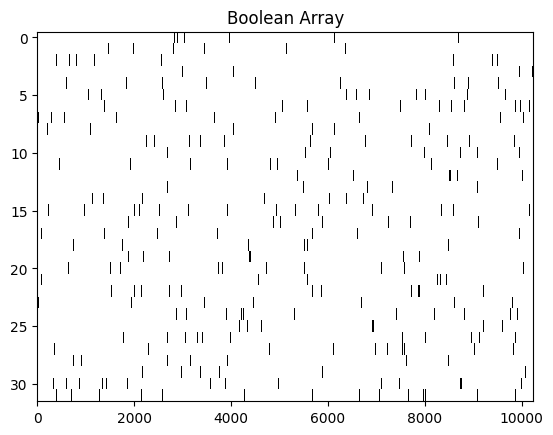

In [27]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.cm.binary
cmap.set_bad('white')

plt.imshow(h_map, cmap=cmap, interpolation='nearest', aspect='auto')
plt.title("Boolean Array")
plt.show()

In [28]:
h_map.shape

(32, 10240)

In [30]:
for l in h_map:
    print(np.count_nonzero(l)/10240)

0.01201171875
0.01435546875
0.0146484375
0.0126953125
0.01328125
0.01552734375
0.0150390625
0.016796875
0.01591796875
0.0162109375
0.011328125
0.01318359375
0.0140625
0.01220703125
0.01591796875
0.01650390625
0.01748046875
0.0173828125
0.02021484375
0.01689453125
0.01865234375
0.02001953125
0.0236328125
0.01767578125
0.02158203125
0.02197265625
0.0197265625
0.02080078125
0.02021484375
0.017578125
0.0171875
0.015625


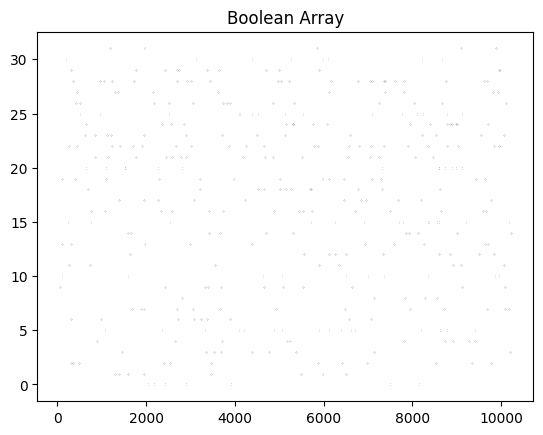

In [20]:
bool_array = h_map

# Get the indices of True values
rows, cols = np.where(bool_array)

# Plot the Boolean array with larger dots for True values
plt.scatter(cols, rows, c='black', s=.01)
plt.title("Boolean Array")
plt.grid(True, color='white')
plt.show()


In [21]:
np.save('/u/amo-d1/grad/mha361/work/My_ff/h_map', h_map)

In [26]:
h_map2 = np.load("/u/amo-d1/grad/mha361/work/My_ff/h_map.npy")